In [1]:
import os 
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import zip_longest
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys
from sklearn.metrics import mean_squared_error 
sys.path.insert(0, '/Users/huripari/Documents/PhD/TCs_Genesis/FS_TCG')
import utils_results as ut

In [2]:
# Set directories
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
fs_dir = os.path.join(project_dir, 'FS_TCG')
results_dir = os.path.join(fs_dir, 'results')
# Set basin array and basin names array
basin_names = ['Global', 'North East Pacific', 'North West Pacific', 'North Atlantic', 'North Indian', 'South Indian', 'South Pacific']
basins = ['GLB', 'NEP', 'NWP', 'NA', 'NI', 'SI', 'SP']
# Set neural network as final model for comparison
FINAL_MODEL = 'mlp'

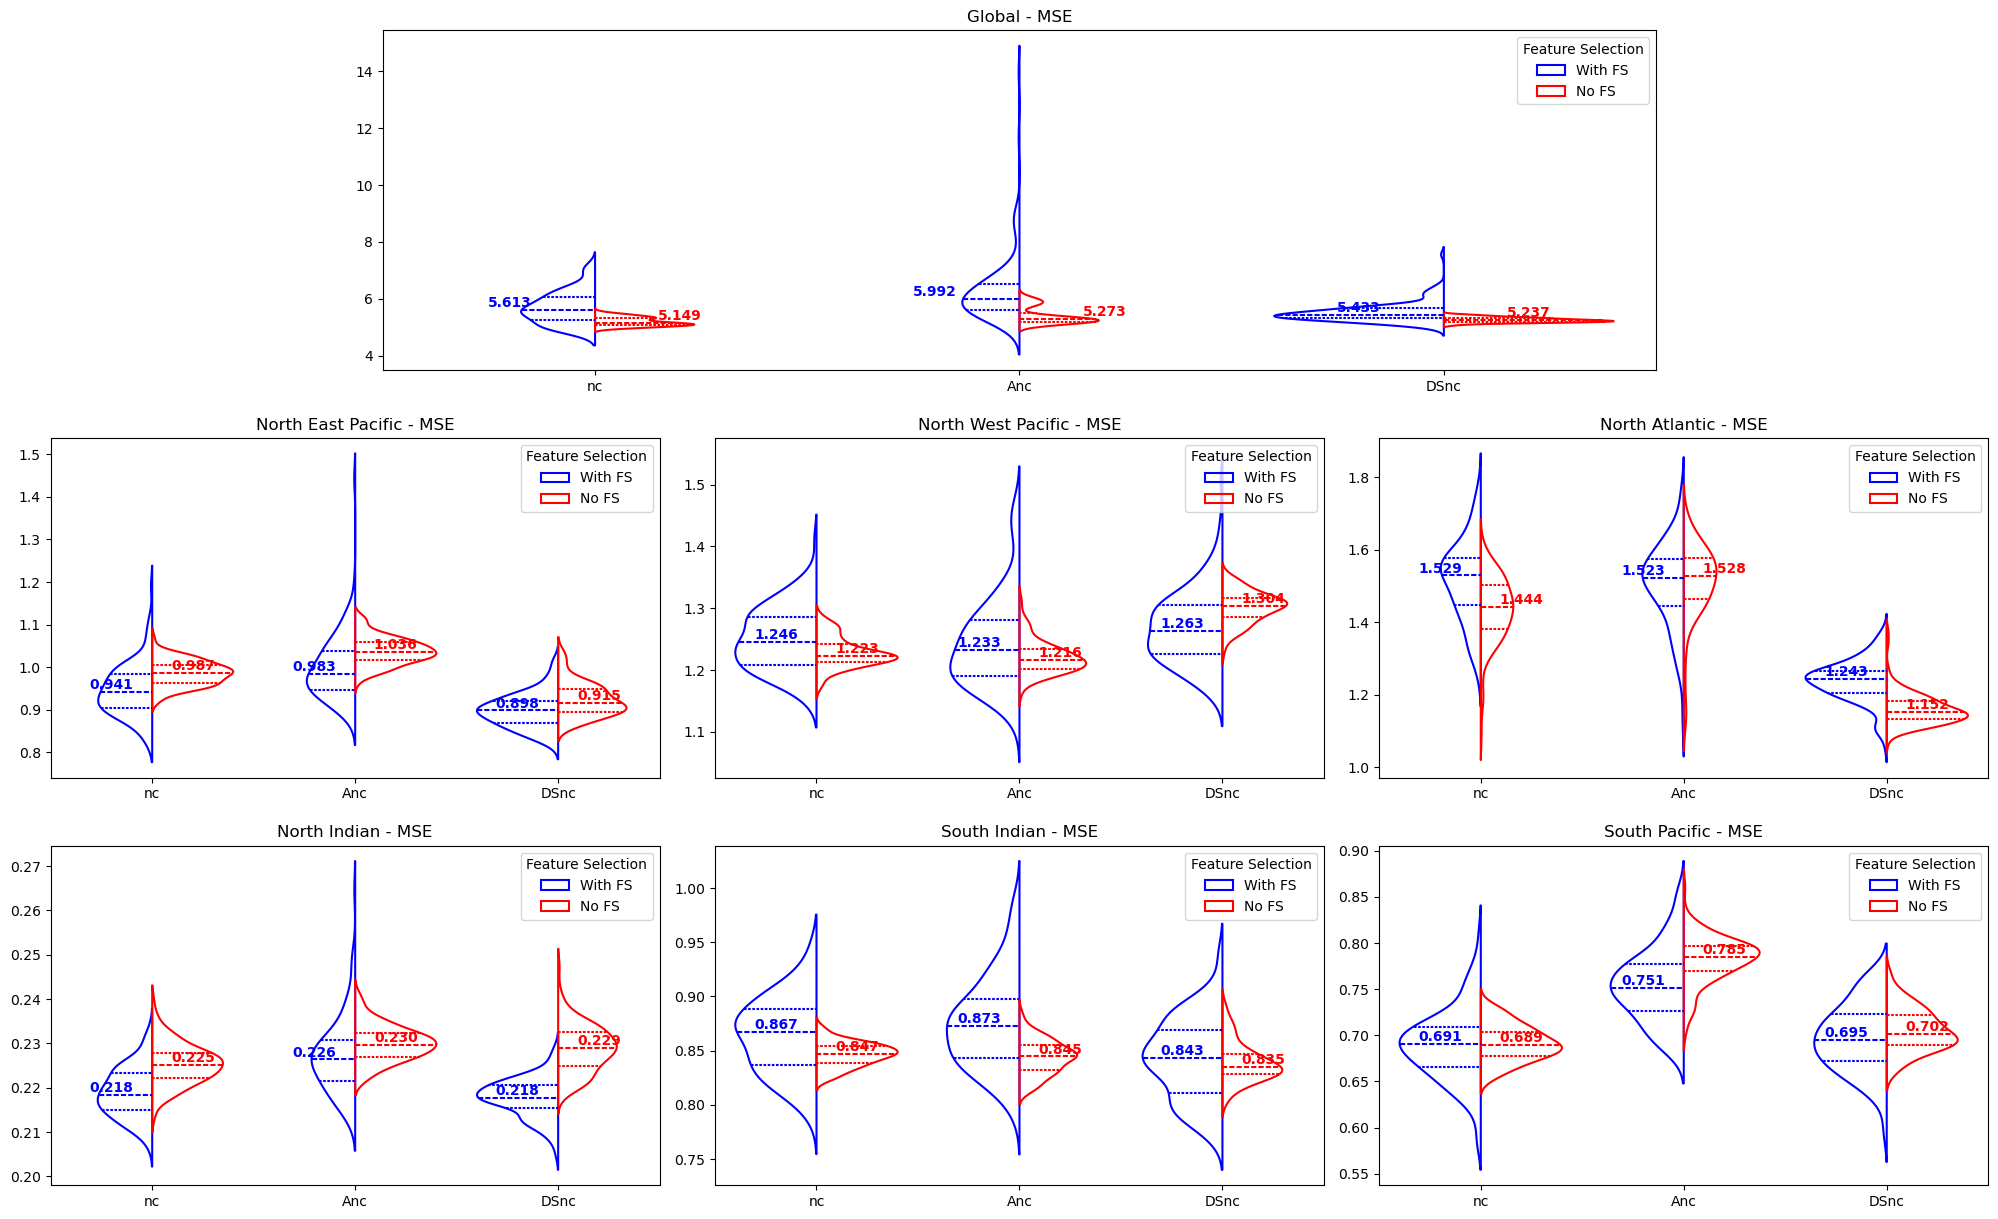

In [10]:
cltype_violin_fig = plt.figure(figsize=(25, 15))
cltype_gs = gridspec.GridSpec(3, 6, figure=cltype_violin_fig)
for bb, basin in enumerate(basins):
    # Load file tracking simulation performance
    track_file = os.path.join(results_dir, f'sim_performance_{basin}.csv')
    track_df = pd.read_csv(track_file, index_col=0)
    track_df = track_df[track_df.index.str.contains('nd9')]
    # Define performance metric columns
    performance_col = f'RMSE_{FINAL_MODEL}'
    performance_col_noFS = f'RMSE_{FINAL_MODEL}_noFS'
    # Filter dataframe based on cluster types
    cluster_types = ['_nc', '_Anc', '_DSnc']
    performance_data = []
    cluster_labels = []
    fs_labels = []
    median_values = []
    hue_labels = []
    for cluster_type in cluster_types:
        sorted_df = track_df[track_df.index.str.contains(cluster_type)].sort_values(performance_col, ascending=True)
        sorted_df_noFS = track_df[track_df.index.str.contains(cluster_type)].sort_values(performance_col_noFS, ascending=True)
        # Extract performance data
        perf_model = sorted_df[performance_col].values ** 2 # Convert RMSE to MSE
        perf_noFS = sorted_df_noFS[performance_col_noFS].values ** 2 # Convert RMSE to MSE
        performance_data.extend([perf_model, perf_noFS])
        cluster_labels.extend([cluster_type.replace('_', '')] * len(perf_model))
        fs_labels.extend(["With FS"] * len(perf_model))
        cluster_labels.extend([cluster_type.replace('_', '')] * len(perf_noFS))
        fs_labels.extend(["No FS"] * len(perf_noFS))
        # Store median values for annotation
        median_values.append(np.median(perf_model))
        hue_labels.append("With FS")  # Assign correct hue label
        median_values.append(np.median(perf_noFS))
        hue_labels.append("No FS")  # Assign correct hue label
    # Create DataFrame for seaborn
    plot_df = pd.DataFrame({
        "MSE": [value for sublist in performance_data for value in sublist],
        "Cluster Type": cluster_labels,
        "Feature Selection": fs_labels
    })
    # Define subplot positions
    if basin == 'GLB':
        ax = cltype_violin_fig.add_subplot(cltype_gs[0,1:5])
    elif basin == 'NEP':
        ax = cltype_violin_fig.add_subplot(cltype_gs[1,0:2])
    elif basin == 'NWP':
        ax = cltype_violin_fig.add_subplot(cltype_gs[1,2:4])
    elif basin == 'NA':
        ax = cltype_violin_fig.add_subplot(cltype_gs[1,4:])
    elif basin == 'NI':
        ax = cltype_violin_fig.add_subplot(cltype_gs[2,0:2])
    elif basin == 'SI':
        ax = cltype_violin_fig.add_subplot(cltype_gs[2,2:4])
    elif basin == 'SP':
        ax = cltype_violin_fig.add_subplot(cltype_gs[2,4:])
    # Violin plot with `split=True` to compare FS vs. No FS for each cluster type
    sns.violinplot(
        x="Cluster Type", y="MSE", hue="Feature Selection",
        data=plot_df, ax=ax, inner="quartile", split=True, fill=False,
        palette={"With FS": "blue", "No FS": "red"}
    )
    x_positions = np.arange(len(cluster_types))
    # Add median values to the plot
    for i, (median, hue_label) in enumerate(zip(median_values, hue_labels)):
        color = "blue" if hue_label == "With FS" else "red"
        x_pos = x_positions[i // 2] + (-0.2 if hue_label == "With FS" else 0.2)  # Offset for split violins
        ax.text(x_pos, median, f'{median:.3f}', ha='center', va='bottom', fontsize=10, color=color, fontweight="bold")
    # Set title
    ax.set_title(f'{basin_names[bb]} - MSE')
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.show()

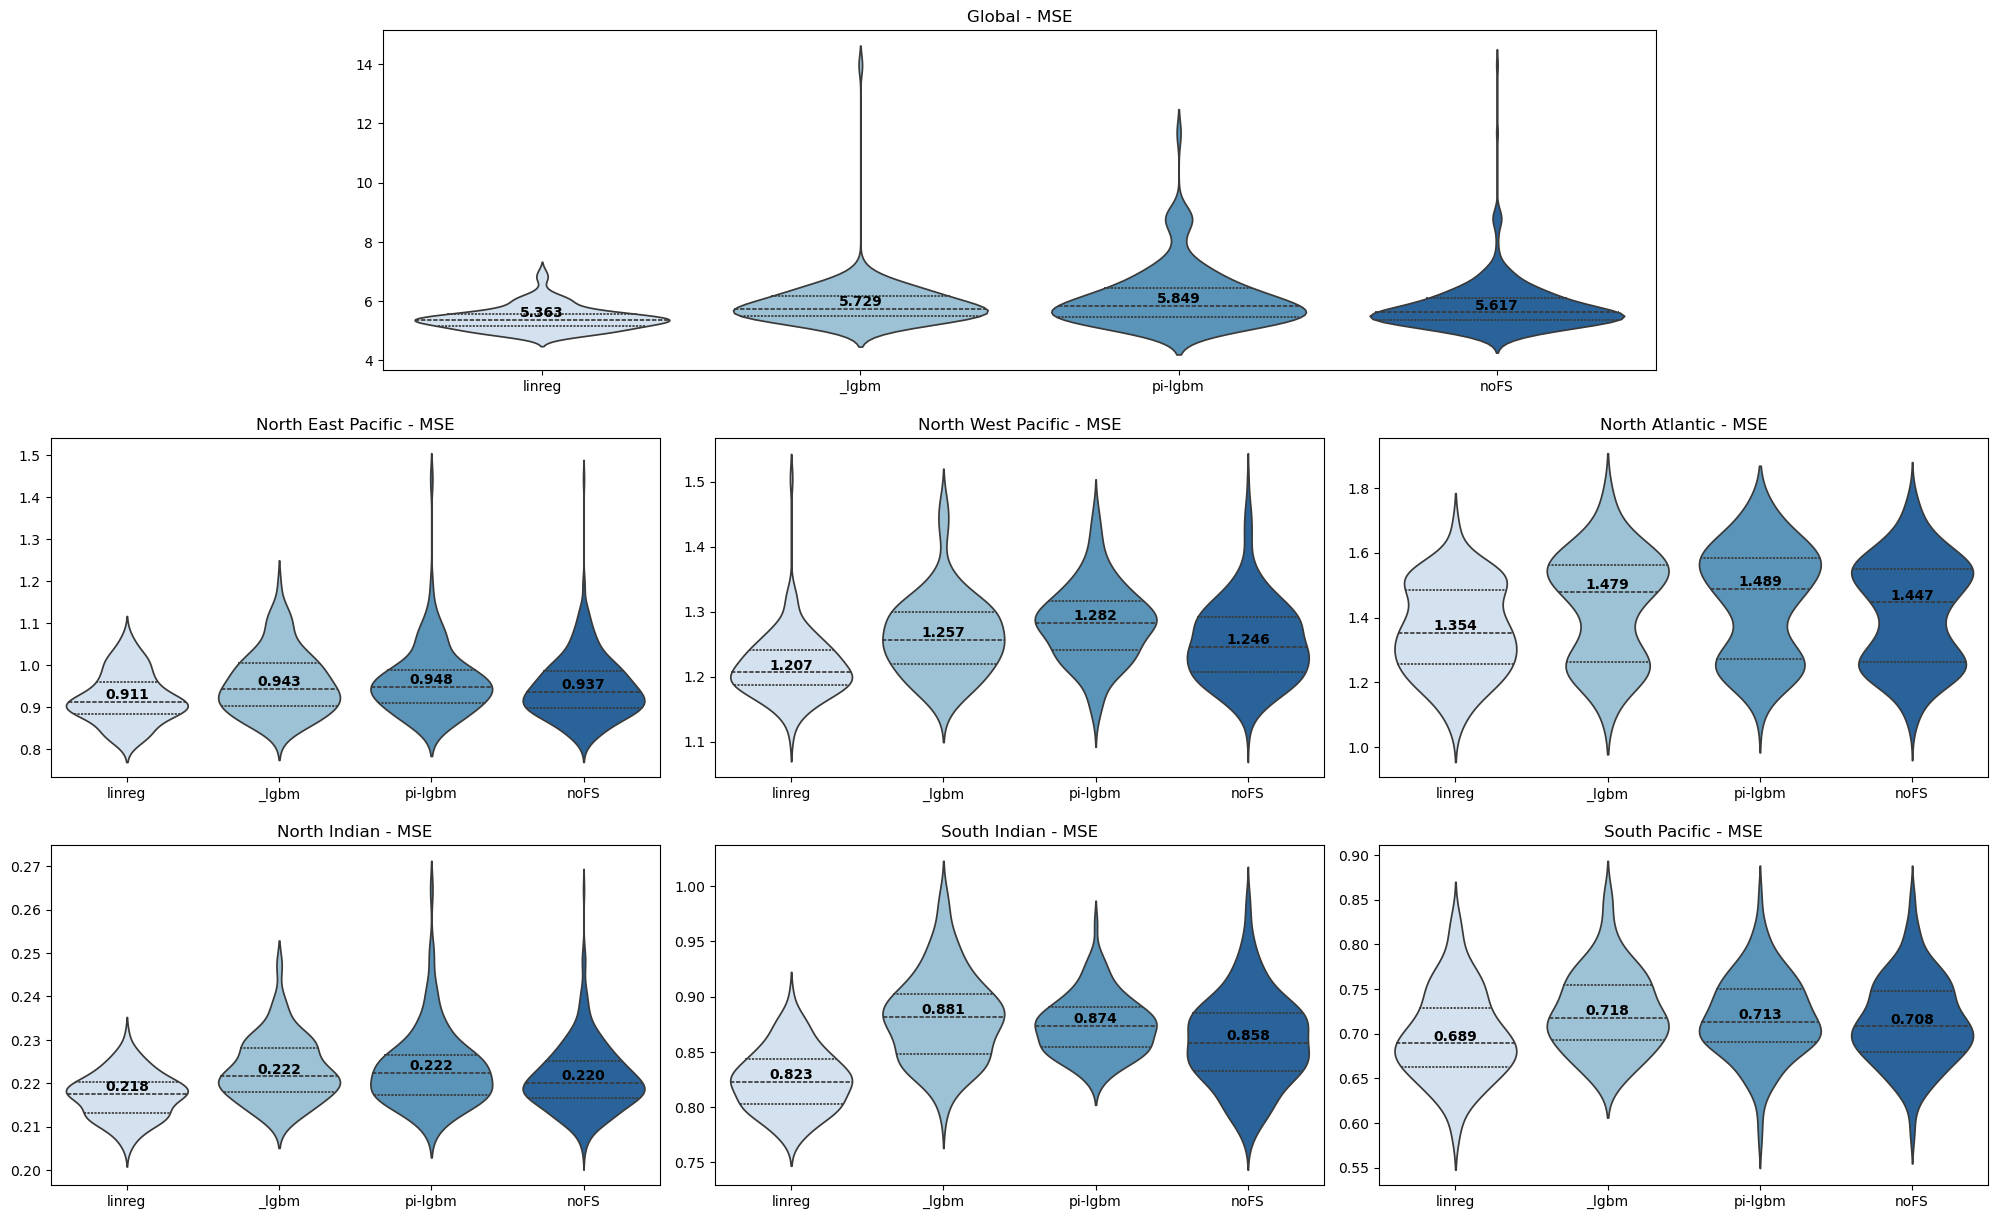

In [11]:
model_violin_fig = plt.figure(figsize=(25, 15))
mods_gs = gridspec.GridSpec(3, 6, figure=model_violin_fig)
for bb, basin in enumerate(basins):
    # Load the file containing the target information
    target_path = os.path.join(fs_dir, 'data', f'{basin}_5clusters', 'target_1970-2022_2.5x2.5.csv')
    target_df = pd.read_csv(target_path, index_col=0)
    target_df.index = pd.to_datetime(target_df.index)
    target_df = target_df.loc['1980':'2021']
    # Load the file containing the information on gpis to compare the mean squared error on the prevision
    gpis_path = os.path.join(fs_dir, 'data', f'{basin}_2.5x2.5_gpis_time_series.csv')
    gpis_df = pd.read_csv(gpis_path, index_col=0)
    gpis_df.index = pd.to_datetime(gpis_df.index)
    gpis_df = gpis_df.loc['1980':'2021']
    # Load file tracking simulation performance
    track_file = os.path.join(results_dir, f'sim_performance_{basin}.csv')
    track_df = pd.read_csv(track_file, index_col=0)
    track_df = track_df[track_df.index.str.contains('nd9')]
    performance_col = f'RMSE_{FINAL_MODEL}'
    sorted_df = track_df.sort_values(performance_col, ascending=True)
    # Create a list to store data for each cluster count
    model_labels = []
    mse_values = []
    median_values = []
    cluster_positions = []
    for model in ['linreg', '_lgbm', 'pi-lgbm', 'noFS']:
        mod_df = sorted_df[sorted_df.index.str.contains(model)] if model != 'noFS' else sorted_df
        mse_vals = mod_df[performance_col].values ** 2  # Convert RMSE to MSE
        mse_values.extend(mse_vals)
        model_labels.extend([model] * len(mse_vals))
        # Store median value
        if len(mse_vals) > 0:
            median_values.append(np.median(mse_vals))
            cluster_positions.append(model)  # Store the cluster position for annotation
    # Create DataFrame for Seaborn
    plot_df = pd.DataFrame({
        "MSE": mse_values,
        "Models": model_labels
    })
    # Define subplot positions
    if basin == 'GLB':
        ax = model_violin_fig.add_subplot(mods_gs[0,1:5])
    elif basin == 'NEP':
        ax = model_violin_fig.add_subplot(mods_gs[1,0:2])
    elif basin == 'NWP':
        ax = model_violin_fig.add_subplot(mods_gs[1,2:4])
    elif basin == 'NA':
        ax = model_violin_fig.add_subplot(mods_gs[1,4:])
    elif basin == 'NI':
        ax = model_violin_fig.add_subplot(mods_gs[2,0:2])
    elif basin == 'SI':
        ax = model_violin_fig.add_subplot(mods_gs[2,2:4])
    elif basin == 'SP':
        ax = model_violin_fig.add_subplot(mods_gs[2,4:])
    # Create violin plot
    sns.violinplot(x="Models", y="MSE", hue="Models", data=plot_df, ax=ax, inner="quartile", palette="Blues", legend=False, fill=True)
    # Annotate median values in black
    x_positions = range(len(cluster_positions))
    for x, median in zip(x_positions, median_values):
        ax.text(x, median, f'{median:.3f}', ha='center', va='bottom', fontsize=10, color='black', fontweight="bold")
    # Set title
    ax.set_title(f'{basin_names[bb]} - MSE')
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.show()

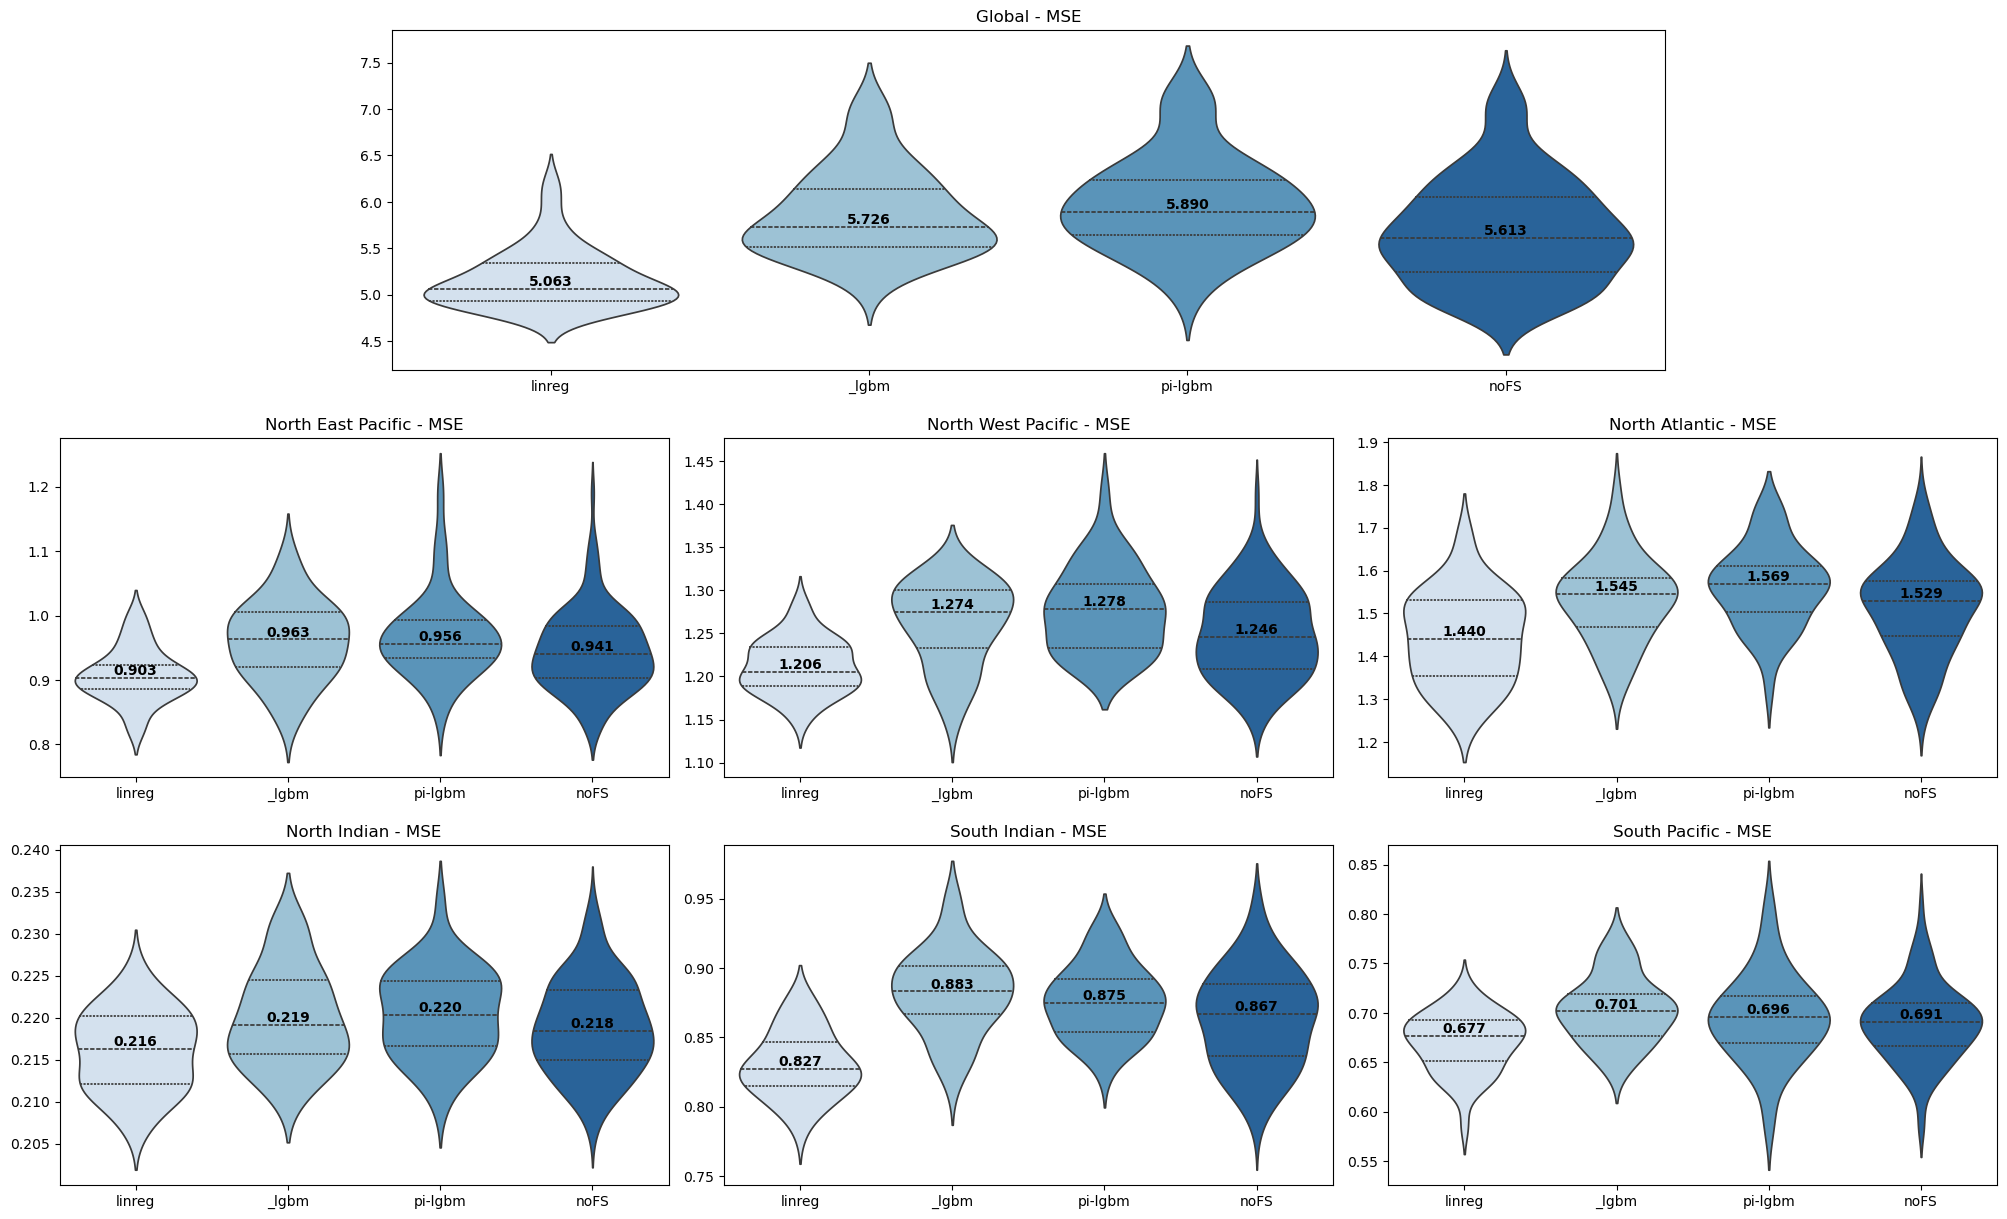

In [14]:
CLUSTER_TYPE = '_nc'  # Options: '_nc', '_Anc', '_DSnc'

model_violin_fig = plt.figure(figsize=(25, 15))
mods_gs = gridspec.GridSpec(3, 6, figure=model_violin_fig)
for bb, basin in enumerate(basins):
    # Load the file containing the target information
    target_path = os.path.join(fs_dir, 'data', f'{basin}_5clusters', 'target_1970-2022_2.5x2.5.csv')
    target_df = pd.read_csv(target_path, index_col=0)
    target_df.index = pd.to_datetime(target_df.index)
    target_df = target_df.loc['1980':'2021']
    # Load the file containing the information on gpis to compare the mean squared error on the prevision
    gpis_path = os.path.join(fs_dir, 'data', f'{basin}_2.5x2.5_gpis_time_series.csv')
    gpis_df = pd.read_csv(gpis_path, index_col=0)
    gpis_df.index = pd.to_datetime(gpis_df.index)
    gpis_df = gpis_df.loc['1980':'2021']
    # Load file tracking simulation performance
    track_file = os.path.join(results_dir, f'sim_performance_{basin}.csv')
    track_df = pd.read_csv(track_file, index_col=0)
    track_df = track_df[track_df.index.str.contains('nd9')]
    track_df = track_df[track_df.index.str.contains(CLUSTER_TYPE)]
    performance_col = f'RMSE_{FINAL_MODEL}'
    sorted_df = track_df.sort_values(performance_col, ascending=True)
    # Create a list to store data for each cluster count
    model_labels = []
    mse_values = []
    median_values = []
    cluster_positions = []
    for model in ['linreg', '_lgbm', 'pi-lgbm', 'noFS']:
        mod_df = sorted_df[sorted_df.index.str.contains(model)] if model != 'noFS' else sorted_df
        mse_vals = mod_df[performance_col].values ** 2  # Convert RMSE to MSE
        mse_values.extend(mse_vals)
        model_labels.extend([model] * len(mse_vals))
        # Store median value
        if len(mse_vals) > 0:
            median_values.append(np.median(mse_vals))
            cluster_positions.append(model)  # Store the cluster position for annotation
    # Create DataFrame for Seaborn
    plot_df = pd.DataFrame({
        "MSE": mse_values,
        "Models": model_labels
    })
    # Define subplot positions
    if basin == 'GLB':
        ax = model_violin_fig.add_subplot(mods_gs[0,1:5])
    elif basin == 'NEP':
        ax = model_violin_fig.add_subplot(mods_gs[1,0:2])
    elif basin == 'NWP':
        ax = model_violin_fig.add_subplot(mods_gs[1,2:4])
    elif basin == 'NA':
        ax = model_violin_fig.add_subplot(mods_gs[1,4:])
    elif basin == 'NI':
        ax = model_violin_fig.add_subplot(mods_gs[2,0:2])
    elif basin == 'SI':
        ax = model_violin_fig.add_subplot(mods_gs[2,2:4])
    elif basin == 'SP':
        ax = model_violin_fig.add_subplot(mods_gs[2,4:])
    # Create violin plot
    sns.violinplot(x="Models", y="MSE", hue="Models", data=plot_df, ax=ax, inner="quartile", palette="Blues", legend=False, fill=True)
    # Annotate median values in black
    x_positions = range(len(cluster_positions))
    for x, median in zip(x_positions, median_values):
        ax.text(x, median, f'{median:.3f}', ha='center', va='bottom', fontsize=10, color='black', fontweight="bold")
    # Set title
    ax.set_title(f'{basin_names[bb]} - MSE')
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.show()

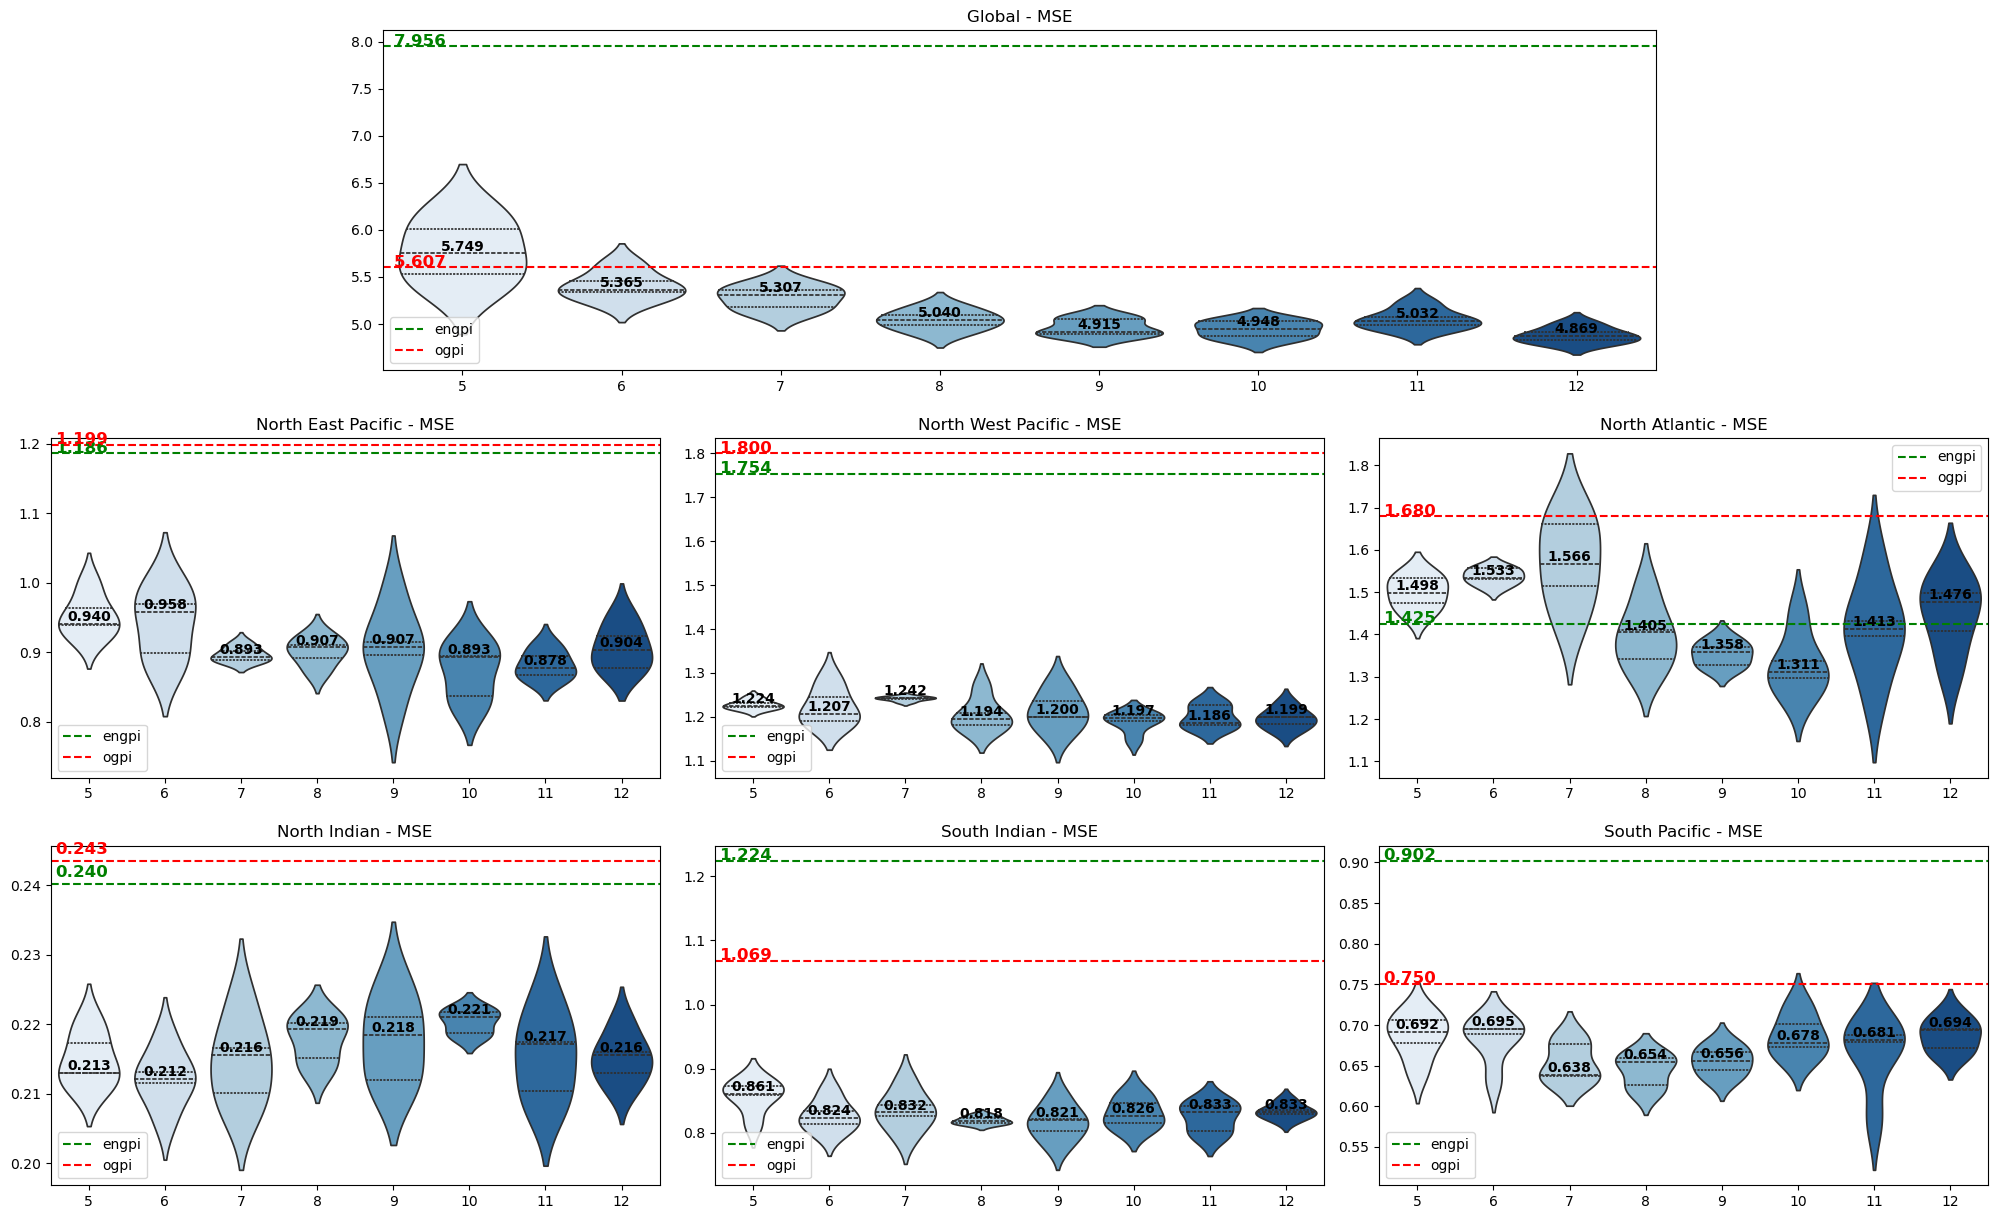

In [17]:
MODEL_KIND = 'linreg' # Options: 'linreg', '_lgbm', 'pi-lgbm'
CLUSTER_TYPE = '_nc'  # Options: '_nc', '_Anc', '_DSnc'

ncl_violin_fig = plt.figure(figsize=(25, 15))
ncle_gs = gridspec.GridSpec(3, 6, figure=ncl_violin_fig)
for bb, basin in enumerate(basins):
    # Load the file containing the target information
    target_path = os.path.join(fs_dir, 'data', f'{basin}_5clusters', 'target_1970-2022_2.5x2.5.csv')
    target_df = pd.read_csv(target_path, index_col=0)
    target_df.index = pd.to_datetime(target_df.index)
    target_df = target_df.loc['1980':'2021']
    # Load the file containing the information on gpis to compare the mean squared error on the prevision
    gpis_path = os.path.join(fs_dir, 'data', f'{basin}_2.5x2.5_gpis_time_series.csv')
    gpis_df = pd.read_csv(gpis_path, index_col=0)
    gpis_df.index = pd.to_datetime(gpis_df.index)
    gpis_df = gpis_df.loc['1980':'2021']
    # Load file tracking simulation performance
    track_file = os.path.join(results_dir, f'sim_performance_{basin}.csv')
    track_df = pd.read_csv(track_file, index_col=0)
    track_df = track_df[track_df.index.str.contains('nd9')]
    track_df = track_df[track_df.index.str.contains(CLUSTER_TYPE)]
    track_df = track_df[track_df.index.str.contains(MODEL_KIND)]
    performance_col = f'RMSE_{FINAL_MODEL}'
    sorted_df = track_df.sort_values(performance_col, ascending=True)
    # Create a list to store data for each cluster count
    cluster_labels = []
    mse_values = []
    median_values = []
    cluster_positions = []
    for ncl in range(5, 13):
        ncl_df = sorted_df[sorted_df['n_clusters'] == ncl]
        mse_vals = ncl_df[performance_col].values ** 2  # Convert RMSE to MSE
        mse_values.extend(mse_vals)
        cluster_labels.extend([str(ncl)] * len(mse_vals))
        # Store median value
        if len(mse_vals) > 0:
            median_values.append(np.median(mse_vals))
            cluster_positions.append(str(ncl))  # Store the cluster position for annotation
    # Create DataFrame for Seaborn
    plot_df = pd.DataFrame({
        "MSE": mse_values,
        "Clusters": cluster_labels
    })
    # Define subplot positions
    if basin == 'GLB':
        ax = ncl_violin_fig.add_subplot(ncle_gs[0,1:5])
    elif basin == 'NEP':
        ax = ncl_violin_fig.add_subplot(ncle_gs[1,0:2])
    elif basin == 'NWP':
        ax = ncl_violin_fig.add_subplot(ncle_gs[1,2:4])
    elif basin == 'NA':
        ax = ncl_violin_fig.add_subplot(ncle_gs[1,4:])
    elif basin == 'NI':
        ax = ncl_violin_fig.add_subplot(ncle_gs[2,0:2])
    elif basin == 'SI':
        ax = ncl_violin_fig.add_subplot(ncle_gs[2,2:4])
    elif basin == 'SP':
        ax = ncl_violin_fig.add_subplot(ncle_gs[2,4:])
    # Create violin plot
    sns.violinplot(x="Clusters", y="MSE", hue="Clusters", data=plot_df, ax=ax, inner="quartile", palette="Blues", legend=False, fill=True)
    # Annotate median values in black
    x_positions = range(len(cluster_positions))
    for x, median in zip(x_positions, median_values):
        ax.text(x, median, f'{median:.3f}', ha='center', va='bottom', fontsize=10, color='black', fontweight="bold")
    # Add horizontal lines to indicate the mean squared error of the gpis
    engpi_mse = mean_squared_error(target_df['tcg'], gpis_df['engpi'])
    ax.axhline(y=engpi_mse, color='green', linestyle='--', label='engpi')
    ogpi_mse = mean_squared_error(target_df['tcg'], gpis_df['ogpi'])
    ax.axhline(y=ogpi_mse, color='red', linestyle='--', label='ogpi')
    x_pospos = -0.1 if basin == 'GLB' else 0.25
    ax.text(x_pospos, engpi_mse+0.001, f'{engpi_mse:.3f}', color='green', fontsize=12, fontweight="bold", ha='right')
    ax.text(x_pospos, ogpi_mse+0.001, f'{ogpi_mse:.3f}', color='red', fontsize=12, fontweight="bold", ha='right')
    ax.legend()
    # Set title
    ax.set_title(f'{basin_names[bb]} - MSE')
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.show()